In [3]:
import pandas as pd
from zipfile import ZipFile
import os
import requests

url = "https://github.com/JAugusto97/ToLD-Br/raw/main/experiments/data/1annotator.zip"
dir = 'data'

files = [
    'data/1annotator/ptbr_test_1annotator.csv',
    'data/1annotator/ptbr_train_1annotator.csv',
    'data/1annotator/ptbr_validation_1annotator.csv'
]

if not all([os.path.exists(file) for file in files]):
    os.makedirs(dir, exist_ok=True)

    response = requests.get(url)
    zip_path = os.path.join(dir, '1annotator.zip')
    with open(zip_path, 'wb') as file:
        file.write(response.content)

    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)

df_test = pd.read_csv('data/1annotator/ptbr_test_1annotator.csv')
df_train = pd.read_csv('data/1annotator/ptbr_train_1annotator.csv')
df_val = pd.read_csv('data/1annotator/ptbr_validation_1annotator.csv')

In [4]:
df_test.head()

,text,toxic
0,@user nossa mano te odeio na moral kkkkkkkkkkk...,1
1,@user @user a edição ficou muito boa! kkkkkkkk...,0
2,"@user largada vá, visto que a vaca anda à solta 😂",0
3,"poxa, eu queria ganhar um boné. alguém me da u...",0
4,"@user amiga, tudo bem, não precisa se desculpa...",1


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from nltk.corpus import stopwords
import nltk
import re
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

nltk.download('stopwords')

portuguese_stopwords = set(stopwords.words('portuguese'))

def preprocess_text(series):
  def preprocess_single_text(text):
    text = re.sub(r'http\S+', '', text)  # Remover URLs
    text = re.sub(r'@\w+', '', text)  # Remover @user
    text = text.lower()  # Converter pra lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remover punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remover espaços

    tokens = [stemmer.stem(word) for word in text.split() if word not in portuguese_stopwords]
    
    return ' '.join(tokens)
  
  return series.apply(preprocess_single_text)

pipeline = Pipeline([
  ('preprocess', FunctionTransformer(preprocess_text)),
  ('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1, 3))),
  ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train = df_train['text']
y_train = df_train['toxic']

X_test = df_test['text']
y_test = df_test['toxic']

[nltk_data] Downloading package rslp to /Users/pedro/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7200


Balanced Accuracy: 0.7227

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2111
           1       0.73      0.63      0.68      1669

    accuracy                           0.73      3780
   macro avg       0.73      0.72      0.72      3780
weighted avg       0.73      0.73      0.73      3780


Top 20 most important words for classification:
1. cu (0.029665)
2. porr (0.018472)
3. caralh (0.014739)
4. put (0.011070)
5. fud (0.009615)
6. pqp (0.008925)
7. pau (0.006563)
8. fod (0.006276)
9. fdp (0.006075)
10. tom cu (0.005695)
11. rt (0.005219)
12. vagabund (0.005196)
13. burr (0.004829)
14. filh put (0.004745)
15. car (0.004546)
16. tom (0.003632)
17. babac (0.003629)
18. piranh (0.003590)
19. fei (0.003434)
20. filh (0.003397)


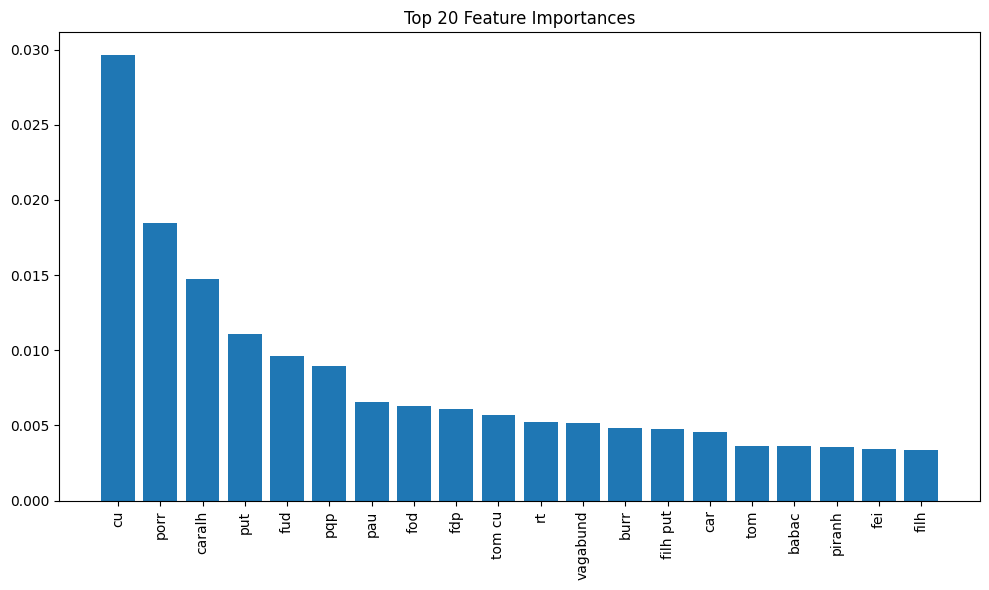

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
import numpy as np

df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

X = df_combined['text']
y = df_combined['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

tfidf_vectorizer = pipeline.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names_out()

rf_classifier = pipeline.named_steps['classifier']
importances = rf_classifier.feature_importances_

indices = np.argsort(importances)[::-1]

print("\nTop 20 most important words for classification:")
for f in range(min(20, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

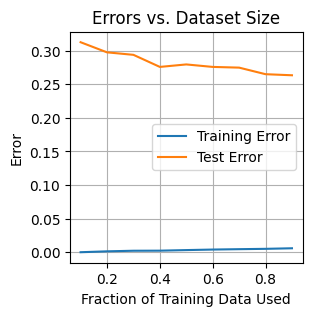

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

def downsample_data(X, y, size):
  X_downsampled, _, y_downsampled, _ = train_test_split(X, y, train_size=size, random_state=42)
  return X_downsampled, y_downsampled

sizes = np.linspace(0.1, 0.9, 9)

train_errors = []
test_errors = []

for size in sizes:
  X_train_downsampled, y_train_downsampled = downsample_data(X_train, y_train, float(size))
  
  pipeline.fit(X_train_downsampled, y_train_downsampled)
  
  y_train_pred = pipeline.predict(X_train_downsampled)
  train_error = 1 - accuracy_score(y_train_downsampled, y_train_pred)
  train_errors.append(train_error)
  
  y_test_pred = pipeline.predict(X_test)
  test_error = 1 - accuracy_score(y_test, y_test_pred)
  test_errors.append(test_error)

plt.figure(figsize=(3, 3))
plt.plot(sizes, train_errors, label='Training Error')
plt.plot(sizes, test_errors, label='Test Error')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('Error')
plt.title('Errors vs. Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_train_vectorized)

def display_topics(model, feature_names, no_top_words):
  for topic_idx, topic in enumerate(model.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

class TwoLayerClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, topic_model, topic_vectorizer, classifiers):
    self.topic_model = topic_model
    self.topic_vectorizer = topic_vectorizer
    self.classifiers = classifiers

  def fit(self, X, y):
    X_vectorized = self.topic_vectorizer.fit_transform(X)
    self.topic_model.fit(X_vectorized)
    topics = self.topic_model.transform(X_vectorized).argmax(axis=1)
    for topic in range(self.topic_model.n_components):
      topic_indices = (topics == topic)
      if topic_indices.sum() > 0:
        self.classifiers[topic].fit(X[topic_indices], y[topic_indices])
    return self

  def predict(self, X):
    X_vectorized = self.topic_vectorizer.transform(X)
    topics = self.topic_model.transform(X_vectorized).argmax(axis=1)
    predictions = []
    for i, topic in enumerate(topics):
      predictions.append(self.classifiers[topic].predict([X.iloc[i]])[0])
    return predictions

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

classifiers = [make_pipeline(TfidfVectorizer(max_features=50000, ngram_range=(1, 2)), 
         RandomForestClassifier(n_estimators=100, random_state=42)) for _ in range(10)]
two_layer_classifier = TwoLayerClassifier(topic_model, topic_vectorizer, classifiers)

two_layer_classifier.fit(X_train_split, y_train_split)

y_val_pred = two_layer_classifier.predict(X_val_split)

val_accuracy = accuracy_score(y_val_split, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Topic 0:
eu com muito que caralho 12 pra mais sou isso
Topic 1:
da um que com eu mais na os meu sem
Topic 2:
eu pra cu que não vai mas tomar na user
Topic 3:
user rt https porra cu vai da seu com tá
Topic 4:
eu não se pra minha que meu vai em com
Topic 5:
que não tem se https você pra uma para com
Topic 6:
user da que um em os se não https por
Topic 7:
que eu user não na pra um puta vou só
Topic 8:
eu que porra da puta https minha um mais pra
Topic 9:
pqp user caralho que um eu https rt esse mano


NameError: name 'topic_model' is not defined